# Baseline Linear Regression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots
from utils.modeling import fit_cv_models, predict_cv_ensemble
from utils.logging import log_run_json


train_df, test_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

train_df = add_shift_raw_column(train_df, spo2_to_po2)
test_df  = add_shift_raw_column(test_df, spo2_to_po2)

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
features = ['shift_raw', 'PiO2(kPa)', 'SpO2(%)']

# Train ensemble of CV models
cv_models = fit_cv_models(
    train_df,
    features=features,
    target_col='shift',
    model_class=LinearRegression,
    k=10
)

# Predict on test set (average over CV models)
test_df['y_pred'] = predict_cv_ensemble(test_df, features, cv_models)

# Evaluate macro-averaged patient metrics
summary = evaluate_macro_patient_level(test_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(summary)


Macro-averaged per-patient metrics:
MAE  = 1.017
MSE  = 2.693
RMSE = 1.212
Mean Bias Error = 0.028
MAPE = 9.511%
nRMSE = 6.446%


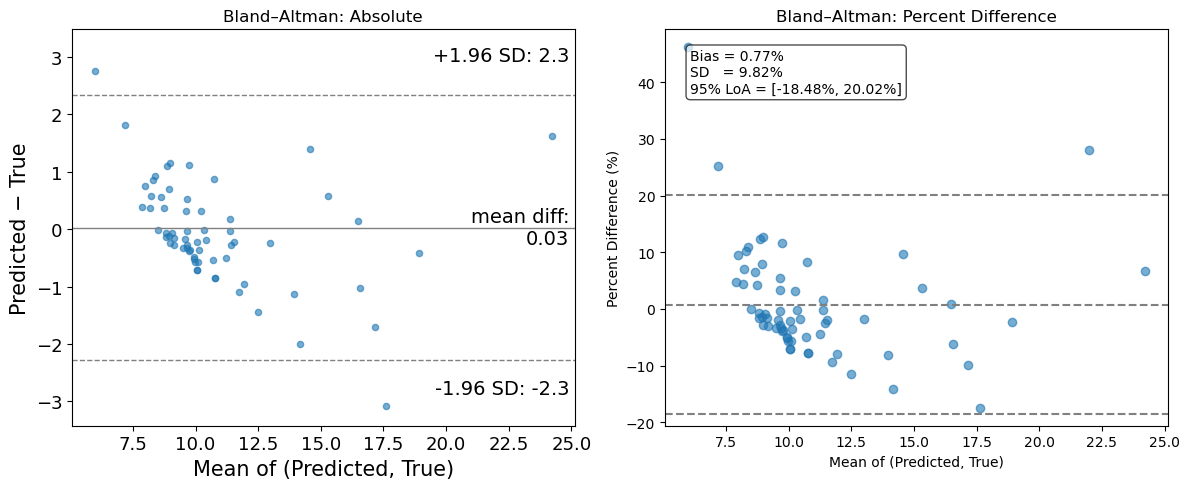

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [4]:
bland_altman_plots(test_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


In [8]:
description = f'''
Model: Linear Regression Baseline
Description: This model uses a linear regression approach to predict the shift in PiO2 based on the raw shift, PiO2, and SpO2 values. It is trained on a dataset of neonatal patients with ODC data.
Features: shift_raw, PiO2(kPa), SpO2(%)
Target: shift
Notes: patient-level macro metrics, ODC from neonatal table
'''

# Filter only scalar (JSON-serializable) entries
json_safe_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in summary.items()
    if not isinstance(v, pd.Series)
}

json_path = RESULTS_PATH / "single_point_model_metrics_log.json"

log_run_json(
    identifier="Linear Regression Baseline",
    model_type="Linear Regression",
    features=features,
    train_subset="full train set",
    test_subset="full test set",
    description=description,
    metrics=json_safe_metrics,
    json_path=json_path
)


✅ Logged run #1 ➜ /Users/sarah/Code/neonatal-odc-shift/results/single_point_model_metrics_log.json


In [6]:

test_df  = test_df[test_df['SpO2(%)'] < 95].copy()

# Create log feature
train_df['log_PiO2'] = np.log(train_df['Insp.O2(kPa)'])
test_df['log_PiO2'] = np.log(test_df['Insp.O2(kPa)'])

# ===============================================================

features = ['shift_raw', 'log_PiO2', 'SpO2(%)']

# Train ensemble of CV models
cv_models = fit_cv_models(
    train_df,
    features=features,
    target_col='shift',
    model_class=LinearRegression,
    k=10
)

# Predict on test set (average over CV models)
test_df['y_pred'] = predict_cv_ensemble(test_df, features, cv_models)

# Evaluate macro-averaged patient metrics
summary = evaluate_macro_patient_level(test_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(summary)


KeyError: 'Insp.O2(kPa)'